<a href="https://colab.research.google.com/github/miurazzo/RNA-seq-pipeline/blob/main/RNA_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNA-seq pipeline 
From FASTQ to Differential Expression (DE) analysis.

Tools used:

* SRA toolkit
* FASTQC 
* MultiQC
* CutAdapt 
* STAR
* samtools
* IGV 
* featureCounts
* DESeq 2 
* ggplot2 

Based on the tutorial of Galaxy team (https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/ref-based/tutorial.html#introduction) we will utilize RNA-seq produced by Brooks et al. 2011. 

This RNA-seq study in *Drosophila melanogaster* is divided in: 

* Pasilla (PS) genes treated with RNAi (RNA interference)
* untreated PS genes

RNA acts inhibiting or depleting expression of target gene. Therefore, we expecte that genes associate with PS pathway will show different pattern expression in comparison with untreated.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:28
🔁 Restarting kernel...


In [ ]:
!conda --version

conda 22.11.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob 
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams["figure.figsize"] = [8.00, 8.00]
plt.rcParams["figure.autolayout"] = True

In [ ]:
# activate R magic

%%capture
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

## 1. Downloading data 

Source: Brooks, A. N., L. Yang, M. O. Duff, K. D. Hansen, J. W. Park et al., 2011 Conservation of an RNA regulatory map between Drosophila and mammals. Genome Research 21: 193–202. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3032923/

We will install **SRA toolkit** to help downloading the dataset we need, which is:

* 4 untreated samples: GSM461176, GSM461177, GSM461178, GSM461182
* 3 treated samples (Pasilla gene depleted by RNAi): GSM461179, GSM461180, GSM461181


### A) Installing SRA toolkit

In [ ]:
%%capture
!wget --output-document sratoolkit.tar.gz https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
!tar -vxzf sratoolkit.tar.gz

In [ ]:
# add sratoolkit executables to PATH 
os.environ['PATH'] += ':/content/sratoolkit.3.0.1-ubuntu64/bin'

### B) Downloading data  

In [ ]:
!mkdir '/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples'
!mkdir '/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/Untreated'
!mkdir '/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/Treated'

In [ ]:
%%shell 

for sample in 'GSM461177' 'GSM461176' 'GSM461178' 'GSM461182'; do
    mkdir "/content/drive/MyDrive/Bioinformatics Pipelines/RNA-seq/Samples/Untreated/$sample"
    prefetch $sample --output-directory "/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/Untreated/$sample"
done

In [ ]:
%%shell 

for sample in "GSM461179" "GSM461180" "GSM461181"; do 
    echo "/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/Treated/$sample"
    mkdir "/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/Treated/$sample"
    prefetch $sample --output-directory "/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/Treated/$sample"
done

Now we convert sra into fastq using fastq-dump command. 

In [ ]:
for sra in glob.glob("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/*/*/*/*.sra", recursive=True):
    !fastq-dump --outdir $(dirname $sra)  --skip-technical  --readids --read-filter 'pass' --dumpbase --split-3 --clip $sra

Below the Supplemental Table 1 of the original paper. It seems that biological replicates contains technical replicates and sometimes single or paired end read. Therefore, we should merge technical replicates when needed. 

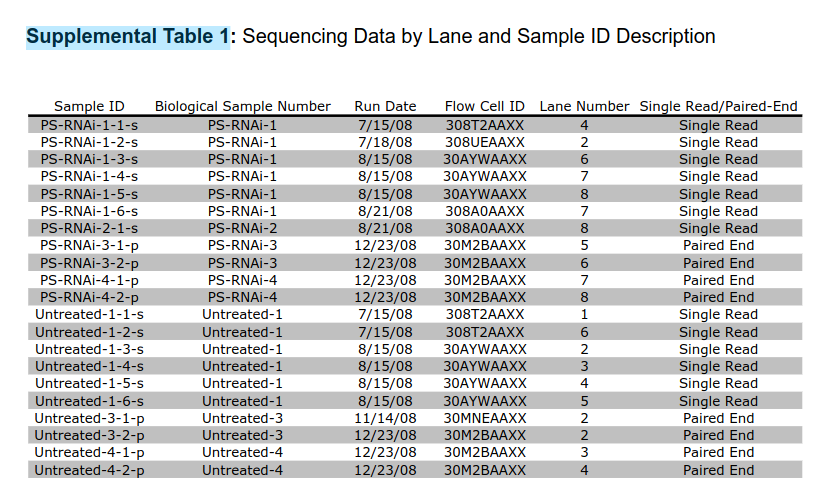

In [ ]:
%%shell 

for cond in 'Treated' 'Untreated'; do
    for sample in /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/$cond/*; do
        name=$(basename $sample)
        echo $name

        # check single reads 
        path=$(find $sample/* -type f -name *pass.fastq | tr '\n' ' ')
        if [[ -n $path ]]; then
            echo $name single read
            cat $path > /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/$cond/${name}.fastq
        fi

        # check paired read 1 
        path1=$(find $sample/* -type f -name *pass_1.fastq | tr '\n' ' ')
        if [[ -n $path1 ]]; then
            echo $name paired 1 
            cat $path1 > /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/$cond/${name}_1.fastq
        fi

        # check paired read 2
        path2=$(find $sample/* -type f -name *pass_2.fastq | tr '\n' ' ')
        if [[ -n $path2 ]]; then
            echo $name paired 2 
            cat $path2 > /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Samples/$cond/${name}_2.fastq
        fi
        
    done
done

## 2. Quality Checking and Trimming Adapters
Using **FASTQC** and **MultiQC** to verify quality of sequenced reads. Then, trimming reads with **CutAdapt**. 


### A) FASTQC
Let's first install FASTQC:

In [ ]:
%%capture 

!apt install fastqc

Let's create a folder to contain all FASTQC results:

In [ ]:
!mkdir /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FASTQC
!mkdir /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FASTQC/Untreated
!mkdir /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FASTQC/Treated

Let's create a env. variable called RNA to placehold our path to the RNA-seq folder, so we don't need to specify this long path all the time:

In [ ]:
%env RNA=/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/
!echo $RNA

env: RNA=/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/
/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/


Now, we run a find command to find all .fastq files in our RNA-seq directory and loop over those paths to run FASTQC: 

In [ ]:
%%shell 

for file in $(find $RNA/Samples/ -maxdepth 2 -type f -name *.fastq ); do
    if [[ $file == *"Treated"* ]]; then
        echo processing $file
        fastqc $file -o $RNA/FASTQC/Treated/ --quiet
        echo finished $file 
    elif [[ $file == *"Untreated"* ]]; then
        echo processing $file
        fastqc $file -o $RNA/FASTQC/Untreated/ --quiet 
        echo finished $file
    fi
done

### B) MultiQC

Let's install MultiQC 

In [ ]:
%%capture 
!conda install -c bioconda multiqc

Creating a directory to contain MultiQC output 

In [ ]:
!mkdir $RNA/multiqc

In [ ]:
!multiqc $RNA/FASTQC/Untreated $RNA/FASTQC/Treated -o $RNA/MultiQC/ 


  /// ]8;id=455980;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.14

|           multiqc | Search path : /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FASTQC/Untreated
|           multiqc | Search path : /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FASTQC/Treated
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 22/22  
|            fastqc | Found 11 reports
|           multiqc | Compressing plot data
|           multiqc | Report      : drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/MultiQC/multiqc_report.html
|           multiqc | Data        : drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/MultiQC/multiqc_data
|           multiqc | MultiQC complete


Let's verify the general stats produced:

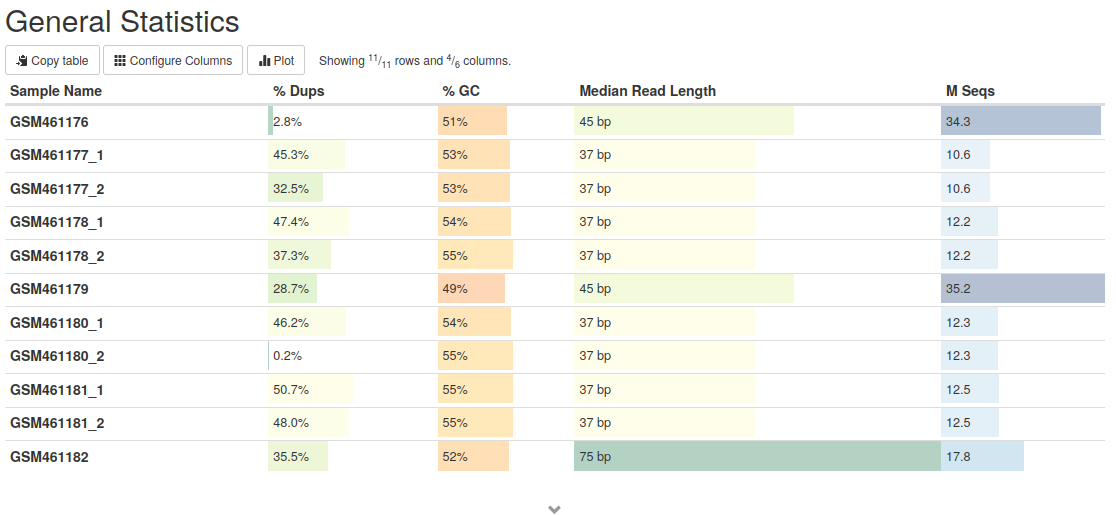

We can see that the ratio of duplicates is high for most samples. We were already expecting that for two reasons:
*  1) since we concatenated technical replicates in one single file. 
*  2) because we are sequencing transcriptome we can expect copies of the same mRNA

We also notice that the median read length varies. In particular, GSM461182 has much longer reads(75 bp) than the average 37 or 45 bp.

In figure below, we can better visualize the total number of reads and the ratio of duplicates in each sample:

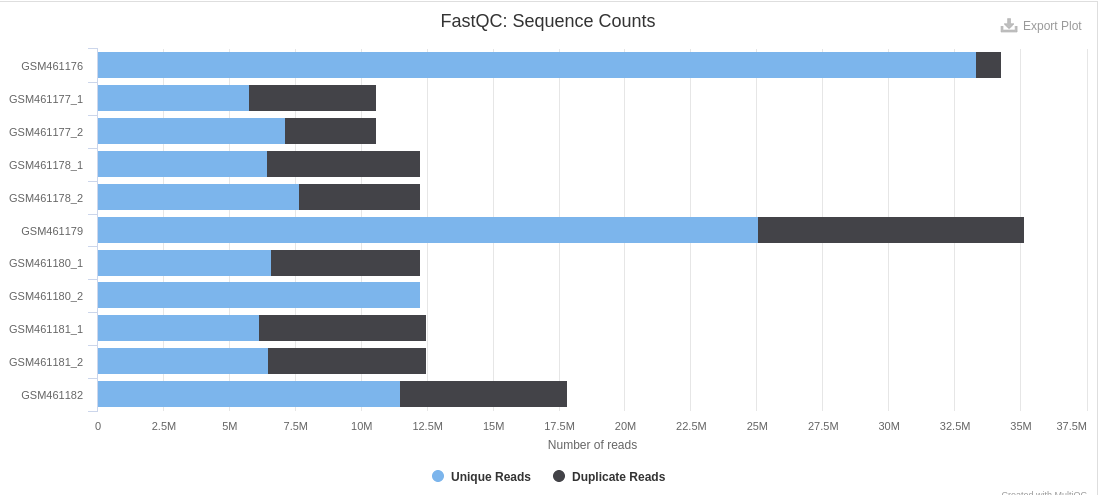

The quality of reads tend to be worse in the 3' end:

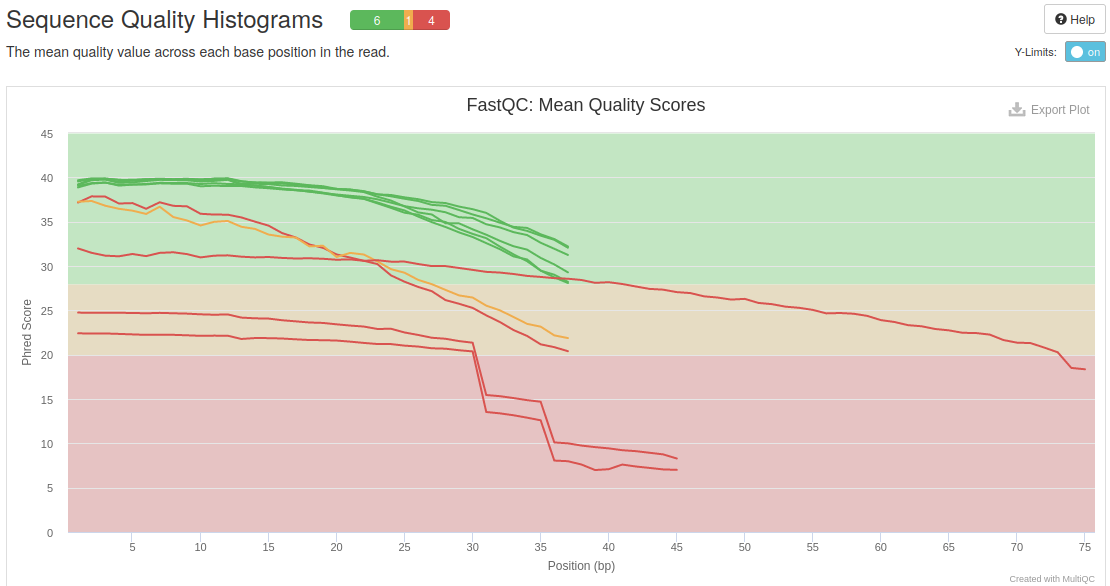

Samples GSM461176 and GSM461179 have very low Phred scores ( starting at 20-25 and ending in 7). 

We can inspect the average quality of reads in the figure below:

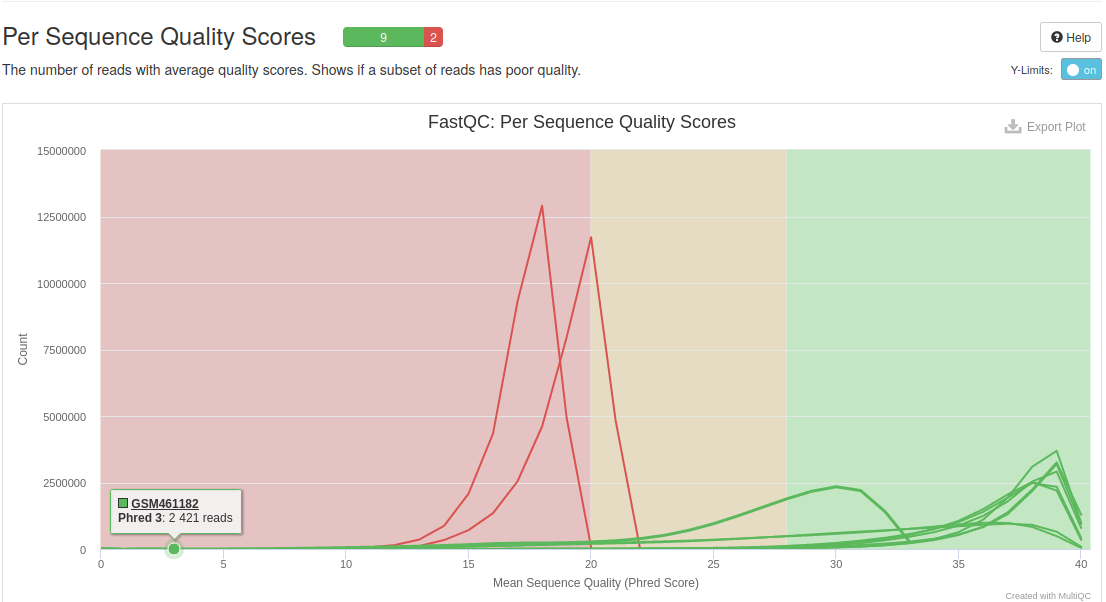

It seems that mostly reads of both GSM461176 and GSM461179 samples have bad quality (Phred score <20). Because we already saw that 3' ends have very low quality, we can expect to have better Mean Sequence Quality after trimming 3' ends. 

Finally, we also have some Ilumina adapters that need to be removed:

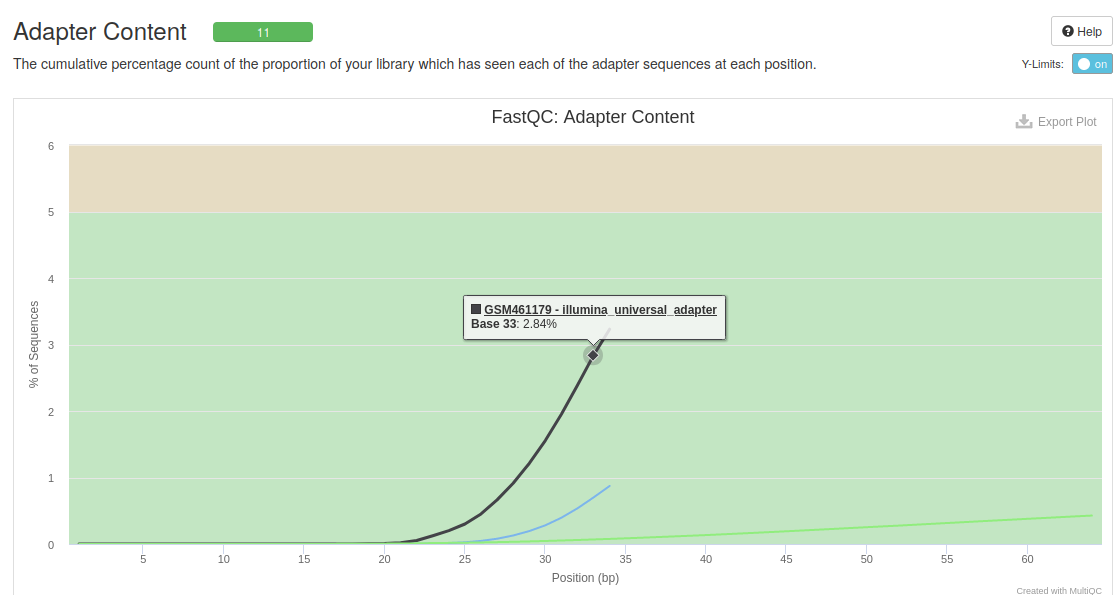

### C) Trimming and removing bad quality reads

Let's install CutAdapt: 

In [ ]:
%%capture 

!conda install -c bioconda cutadapt

I've uploaded a file illumina-adapters.fasta that contains all Illumina adapters we would need to check and remove. Those illumina adapters were shared in a common file thanks to https://gist.github.com/photocyte/3edd9401d0b13476e60f8b104c2575f8

Let's create a folder to CutAdapt output:

In [ ]:
!mkdir $RNA/CutAdapt
!mkdir $RNA/CutAdapt/Untreated
!mkdir $RNA/CutAdapt/Treated

Let's run a shell script to loop over ou fastq files from Samples folder. Our criteria for trimming with CutAdapt is:
 * Remove bases with quality lower than 20 
 * Discard reads with minimum length of 20 bp
 * Remove any Illumina adapter found in 3'end$^1$ using our illumina-adapters.fasta file of adapters. 


We will run a different command for paired-end and for single-end, so we also need to keep track in our script if file contains a _1 and _2 suffix, which indicates paired-end.

**NOTICE** that CutAdapt remove both paired-end reads if any fulfills the above criteria. In this manner, files are in sync.  

$^1$ According to Illumina, adapters are only found in 3' end (https://knowledge.illumina.com/software/general/software-general-reference_material-list/000002905)

In [ ]:
%%shell 

# we create a variable to placehold our adapters fasta path 
ADAPTERS=$RNA/Adapters/illumina-adapters.fasta
OUTPUT=$RNA/CutAdapt

for file in $(find $RNA/Samples/ -maxdepth 2 -type f -name *.fastq ); do
    FILEWEXT=$(basename $file)
    FILEPATH=$(dirname $file)
    # remove .fastq substring
    FILENAME2=${FILEWEXT%%.fastq}
    # remove _1 or _2 if exists 
    FILENAME=${FILENAME2%%_*}
    if [[ $file == *"Treated"* ]]; then
        if [[ $file == *"_1"* ]]; then
            echo processing paired-end $FILENAME 
            cutadapt --pair-filter=any --max-n 0.02 -q 20 --minimum-length=20 -a AGATCGGAAGAG -A AGATCGGAAGAG \ 
                -o $OUTPUT/Treated/${FILENAME}_1.fastq -p $OUTPUT/Treated/${FILENAME}_2.fastq \
                $FILEPATH/${FILENAME}_1.fastq $FILEPATH/${FILENAME}_2.fastq 
        else
            if ! [[ $file == *"_2"* ]]; then
            echo processing single-end $FILENAME 
            cutadapt -q 20 --minimum-length=20  --max-n 0.02 -a AGATCGGAAGAG -o $OUTPUT/Treated/${FILENAME}.fastq  $FILEPATH/${FILENAME}.fastq 
            fi
        fi
            #
    elif [[ $file == *"Untreated"* ]]; then
        if [[ $file == *"_1"* ]]; then
            echo processing paired-end $FILENAME 
            cutadapt --pair-filter=any -q 20 --minimum-length=20  --max-n 0.02 -a AGATCGGAAGAG -A AGATCGGAAGAG \
                -o $OUTPUT/Untreated/${FILENAME}_1.fastq -p $OUTPUT/Untreated/${FILENAME}_2.fastq \
                $FILEPATH/${FILENAME}_1.fastq $FILEPATH/${FILENAME}_2.fastq 
        else
            if ! [[ $file == *"_2"* ]]; then
                echo processing single-end $FILENAME 
                cutadapt -q 20 --minimum-length=20 --max-n 0.02  -a AGATCGGAAGAG -o $OUTPUT/Untreated/${FILENAME}.fastq  $FILEPATH/${FILENAME}.fastq 
            fi
        fi
        
    fi
done

### D) QC after trimming 
Let's run FASTQC and MultiQC again to check if warnings about bad quality reads are gone. 

In [ ]:
%%shell 
#running FASTQC

# we create a variable to placehold our fastq trimmed reads 
INPUT=$RNA/CutAdapt

# creating directories for our FASTQ and MultiQC output 
mkdir $RNA/Post_FASTQC
mkdir $RNA/Post_MultiQC
mkdir $RNA/Post_FASTQC/Treated
mkdir $RNA/Post_FASTQC/Untreated

for file in $(find $RNA/CutAdapt/ -maxdepth 2 -type f -name *.fastq ); do
    if [[ $file == *"Treated"* ]]; then
        echo processing $file
        fastqc $file -o $RNA/Post_FASTQC/Treated/ --quiet
        echo finished $file 
    elif [[ $file == *"Untreated"* ]]; then
        echo processing $file
        fastqc $file -o $RNA/Post_FASTQC/Untreated/ --quiet 
        echo finished $file
    fi
done


mkdir: cannot create directory ‘/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//Post_FASTQC’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//Post_MultiQC’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//Post_FASTQC/Treated’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//Post_FASTQC/Untreated’: File exists
processing /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//CutAdapt/Untreated/GSM461176.fastq
finished /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//CutAdapt/Untreated/GSM461176.fastq
processing /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//CutAdapt/Untreated/GSM461177_1.fastq
finished /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//CutAdapt/Untreated/GSM461177_1.fastq
processing /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//CutAdapt/Untreated/GSM461177_2.fastq
fini

In [ ]:
# Running multiQC 
!multiqc $RNA/Post_FASTQC/Untreated $RNA/Post_FASTQC/Treated -o $RNA/Post_MultiQC/ 


  /// ]8;id=475911;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.14

|           multiqc | Search path : /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Post_FASTQC/Untreated
|           multiqc | Search path : /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Post_FASTQC/Treated
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 22/22  
|            fastqc | Found 11 reports
|           multiqc | Compressing plot data
|           multiqc | Report      : drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Post_MultiQC/multiqc_report.html
|           multiqc | Data        : drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Post_MultiQC/multiqc_data
|           multiqc | MultiQC complete


Let's check the results:

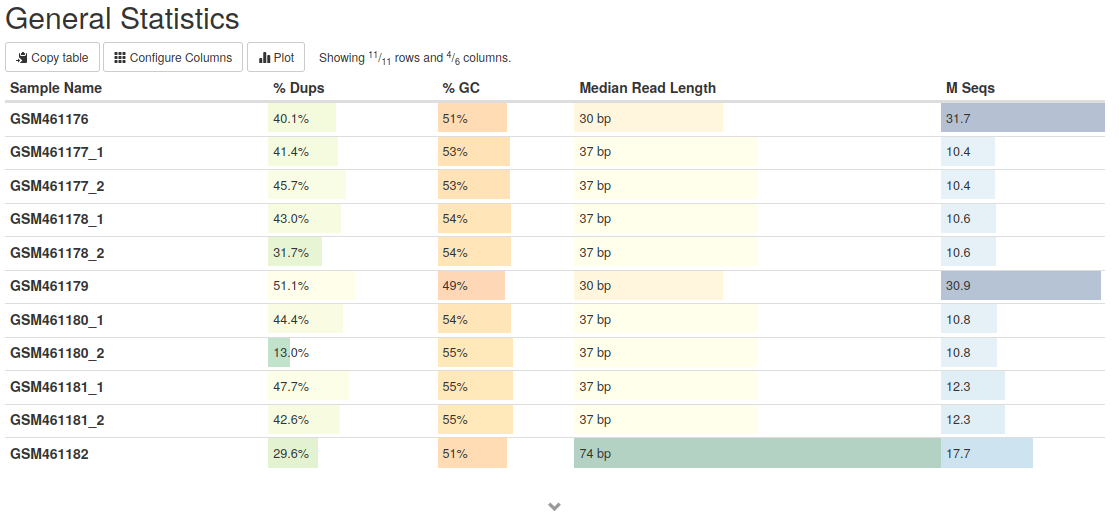

We removed 2-4 million reads on average. We also kept the ratio of duplicates as expected:

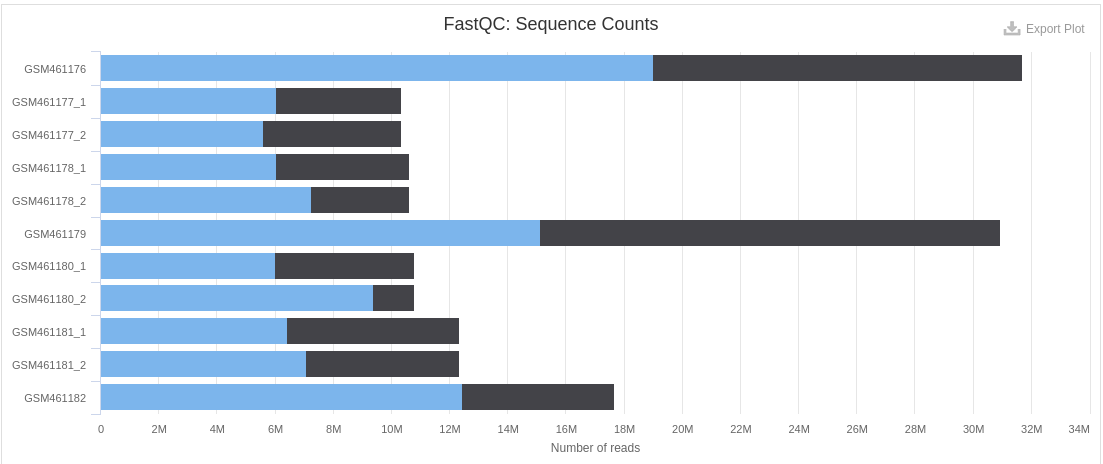

Now we can see that no bad quality base pairs were kept ! This is important, sinc we want to be sure of the nucleotide composition of each read to be mapped to the reference genome in the next step:

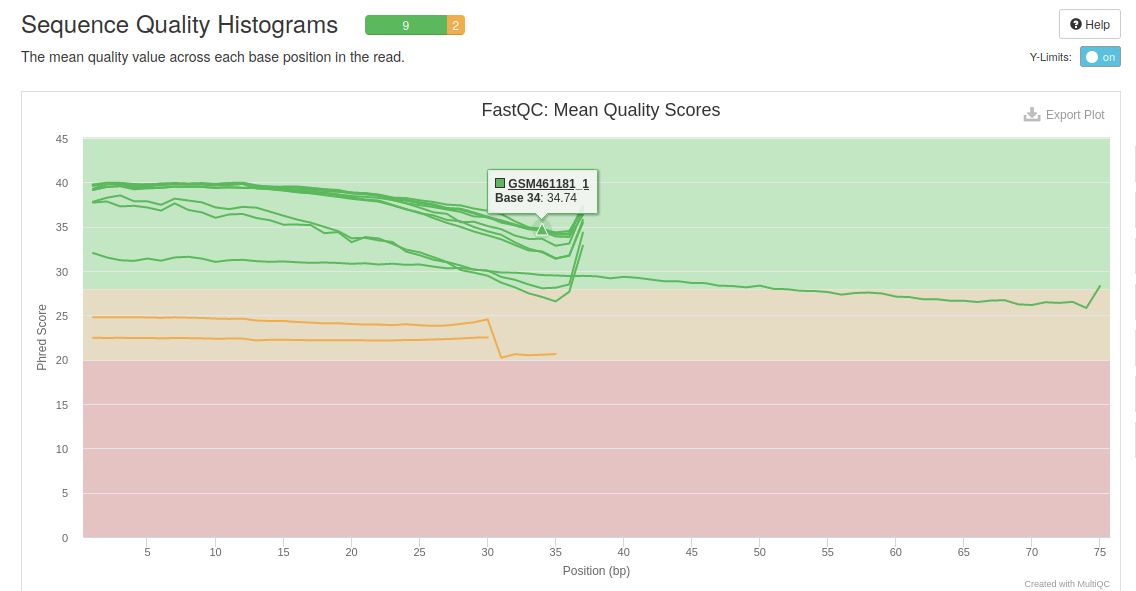

Reads have at least a score 20 on average per sample, which is the acceptable for donwstream analyses:

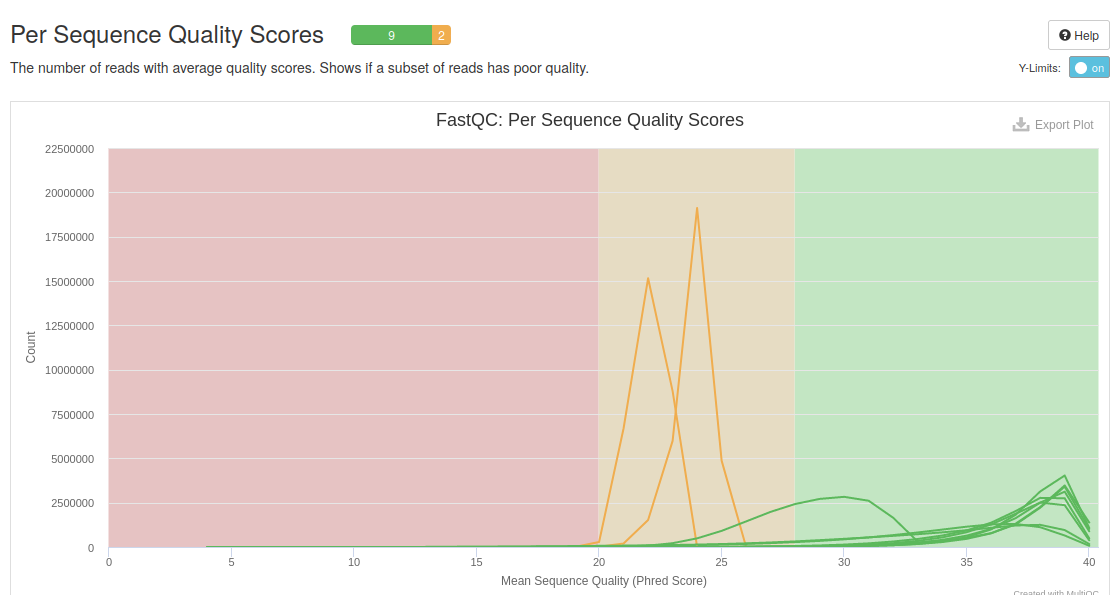

Also, we removed any sign of Illumina Universal Adapter:

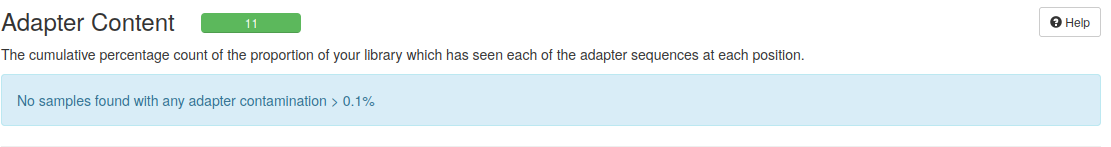

## 3. Mapping reads to reference genome

Now with reads trimmed and filtered by quality we can proceed to map it to the reference genome dm6 of *Drosophila melanogaster*. In the original paper Brooks et al. 2011. chose genome version dm3. But it is recommend to use the latest genome version available. 

### A) Downloading reference genome 

We will download dm6 genome from UCSC 

In [ ]:
!mkdir $RNA/Genome
!wget http://hgdownload.soe.ucsc.edu/goldenPath/dm6/bigZips/dm6.fa.gz -P $RNA/genome


We also need to download the gene annotation so STAR can have a reference of where are the exons and introns in the genome:

In [ ]:
!wget http://hgdownload.soe.ucsc.edu/goldenPath/dm6/bigZips/genes/dm6.ensGene.gtf.gz -P $RNA/genome


### B) Install Star 

We will use **Star** to align reads to dm6 genome. The choice of STAR is due to the fact that most reads were originated from exon sequences (not introns). Star is a spliced mapper, therefore optimized to this task.


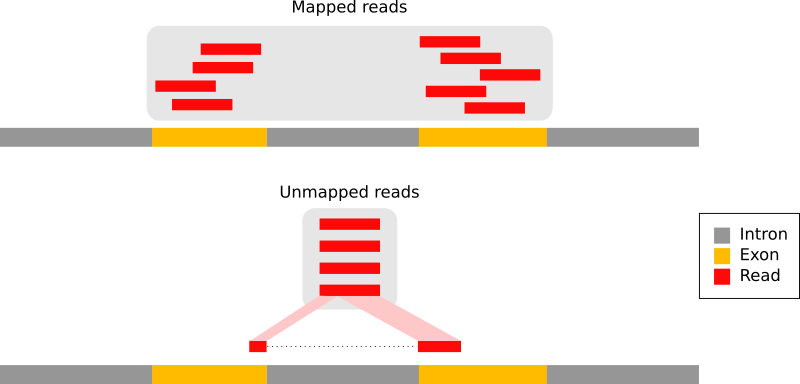

Image source: https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/ref-based/tutorial.html

In [ ]:
%%capture 
# installing with conda pkg manager 
!conda install -c bioconda star

### C) Build a genome index with STAR 

In [ ]:
!mkdir $RNA/STAR/
!mkdir $RNA/STAR/GenomeIndex

When building the index, STAR needs the length of the genomic sequence around the annotated junction, which they recommend to be read length -1.

According to MultiQC, we have different read lenghts:

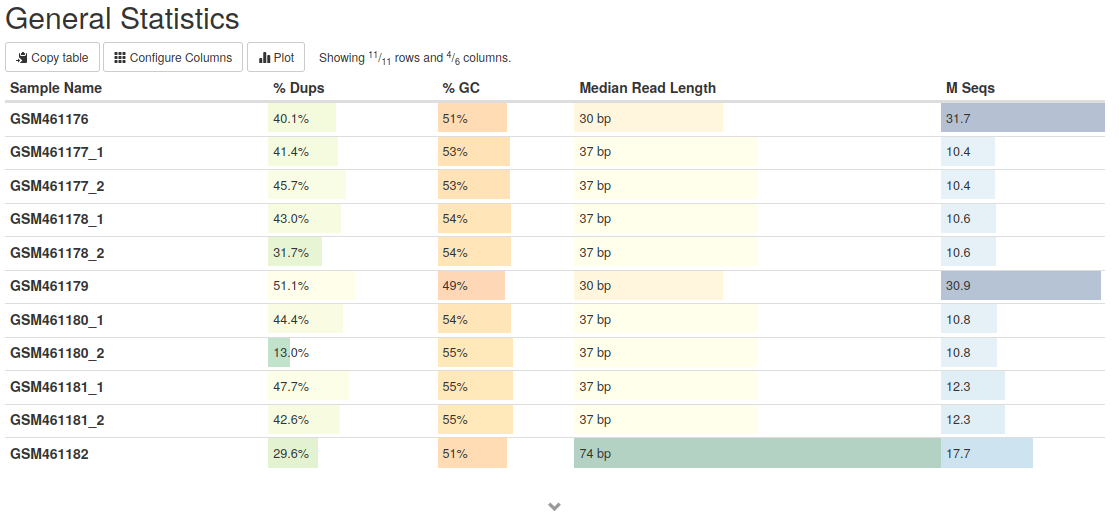

Therefore, we will specify parameter --sjdbOverhang  specifically for each input as being ReadLength -1. We obtain the information we need by reading the table MultiQC provided which correspond to the output image above. 

In [ ]:
# STAR needs genome files decompressed -_-
!gzip -d /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Genome/dm6.fa.gz
!gzip -d /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Genome/dm6.ensGene.gtf.gz

In [ ]:
%%shell

STAR \
--runMode genomeGenerate \
--genomeDir $RNA/STAR/GenomeIndex \
--genomeFastaFiles $RNA/Genome/dm6.fa \

	STAR --runMode genomeGenerate --genomeDir /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//STAR/GenomeIndex --genomeFastaFiles /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//Genome/dm6.fa
	STAR version: 2.7.10b   compiled: 2022-11-01T09:53:26-04:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Mar 24 18:58:44 ..... started STAR run
!!!!! WARNING: Could not move Log.out file from ./Log.out into /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//STAR/GenomeIndex/Log.out. Will keep ./Log.out

Mar 24 18:58:44 ... starting to generate Genome files
!!!!! WARNING: --genomeSAindexNbases 14 is too large for the genome size=143726002, which may cause seg-fault at the mapping step. Re-run genome generation with recommended --genomeSAindexNbases 12
Mar 24 18:58:53 ... starting to sort Suffix Array. This may take a long time...
Mar 24 18:58:56 ... sorting Suffix Array chunks and saving them to disk...
Mar 24 19:03:04 ... loading chunks from disk, packing SA...
Mar 24 1

### D) Running STAR 

Now that we have filtered reads and genome index, we can run STAR. 

**OBS**: I actually runned STAR in my local machine, because Google Colab does not support multithreading. Therefore, **STAR will take long time to finish the task if runned here on Colab**. But the actual shell script that i used to run is showed below:

In [ ]:
# we first set a directory to contain STAR output 
!mkdir $RNA/STAR/Results
!mkdir $RNA/STAR/Results/Treated
!mkdir $RNA/STAR/Results/Untreated

In [ ]:
%%shell

cat $RNA/Post_MultiQC/multiqc_data/multiqc_general_stats.txt | tail +2 > $RNA/Post_MultiQC/nohead_multiqc_general_stats.txt
FILE=$RNA/Post_MultiQC/nohead_multiqc_general_stats.txt

while read line; do

    NAME=$(echo $line | cut -f 1 -d" ")
    # $(( math ))
    READLEN=$(( $(echo $line | cut -f 5 -d" ") -1 ))
    # path of file with NAME 
    PATHNAME=$(find $RNA/CutAdapt/ -type f -name $NAME*)
    # Untreated or Treated 
    CONDITION=$( basename $(dirname $PATHNAME))

    if [[ $NAME == *"_1"* ]]; then
        PNAME=${NAME%%_*}
        echo Processing paired-end $PNAME
        STAR --genomeDir $RNA/STAR/GenomeIndex \
            --readFilesIn $RNA/CutAdapt/$CONDITION/${PNAME}_1.fastq $RNA/CutAdapt/$CONDITION/${PNAME}_2.fastq\
            --outFileNamePrefix $RNA/STAR/Results/$CONDITION/$PNAME \
            --outSAMtype BAM SortedByCoordinate \
            --outSAMattributes Standard \
            --sjdbGTFfile $RNA/Genome/dm6.ensGene.gtf \
            --sjdbOverhang $READLEN \
            --runThreadN 11

    elif ! [[ $NAME == *"_2"* ]]; then
        PNAME=${NAME%%_*}
        echo Processing single-end $NAME
        STAR --genomeDir $RNA/STAR/GenomeIndex \
            --readFilesIn $RNA/CutAdapt/$CONDITION/${PNAME}.fastq \
            --outFileNamePrefix $RNA/STAR/Results/$CONDITION/$PNAME \
            --outSAMtype BAM SortedByCoordinate \
            --outSAMattributes Standard \
            --sjdbGTFfile $RNA/Genome/dm6.ensGene.gtf \
            --sjdbOverhang $READLEN \
            --runThreadN 11
    fi

done < $FILE

### E) Checking STAR log with MultiQC 
MultiQC can aggregate all LOG files from STAR:

In [ ]:
!mkdir $RNA/STAR/MultiQC

In [ ]:
%%shell 

multiqc -m star $RNA/STAR/Results -o $RNA/STAR/MultiQC


  /// ]8;id=638484;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.14

|           multiqc | Only using modules: star
|           multiqc | Search path : /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/STAR/Results
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 84/84  
|              star | Found 7 reports
|           multiqc | Compressing plot data
|           multiqc | Report      : drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/STAR/MultiQC/multiqc_report.html
|           multiqc | Data        : drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/STAR/MultiQC/multiqc_data
|           multiqc | MultiQC complete


We can see that for all samples, at least 76% of the reads were uniquely mapped, corresponding to more than 8.6 million reads mapped.

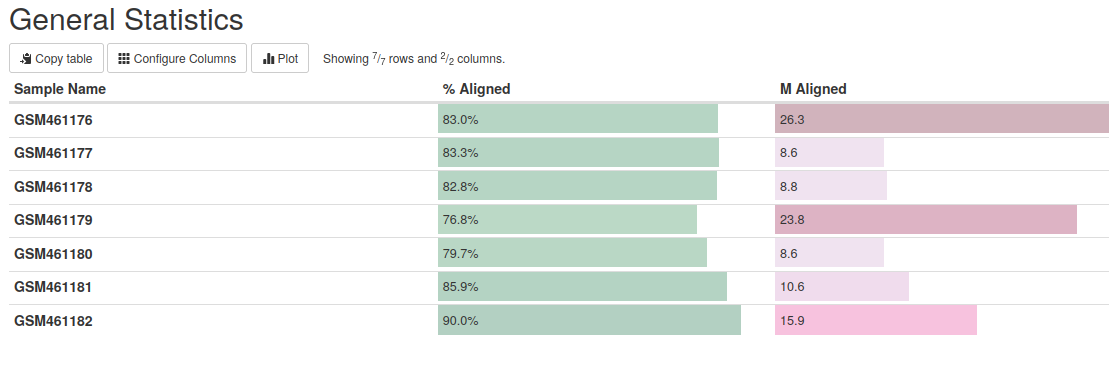

Also, we had some small percentages that were unmapped or mapped to many loci:

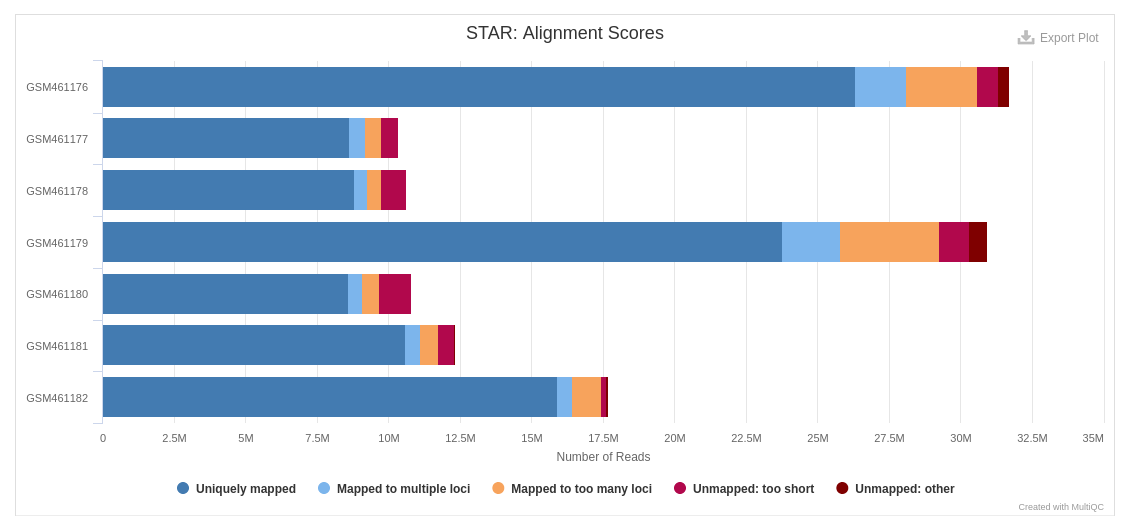

According to [Galaxy tutorial]( https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/ref-based/tutorial.html), only percentages below 70% should be verified for contaminants. So we can proceed since it is not the case for any sample.

## 4. Visualizing STAR alignment with IGV 

**[IGV](https://software.broadinstitute.org/software/igv/)** can be installed locally on machine (see ) . It requires that for each BAM file exists an associate index (.BAI) file. 

### A) installing samtools

In [ ]:
%%capture 

!conda install -c bioconda samtools

### B) Creating BAM index files 
We can create an index using **samtools** sort and index command.

In [ ]:
!mkdir $RNA/Samtools

In [ ]:
%%shell

# Untreated condition in STAR/Results folder 
for bam in $(find $RNA/STAR/Results -type f -name '*bam*' | tr '\n' ' '); do 
    # get filename with extension
    FILENAME3=$(basename $bam)
    # remove extension 
    FILENAME2=${FILENAME3%%.*bam*}
    # remove "Aligned" substring 
    FILENAME=${FILENAME2:0:9}
    echo sorting $FILENAME
    samtools sort $bam -o $RNA/Samtools/${FILENAME}.bam
    echo indexing $FILENAME
    samtools index $RNA/Samtools/${FILENAME}.bam -o $RNA/Samtools/${FILENAME}.bam.bai
done

### C) Inspecting STAR aligment with IGV 
Finally, we can visualize an specific region of interest (Chr4: between 540 kbp and 560 kbp)  for a given sample, say GSM461177 (paired-end Untreated condition) in IGV:

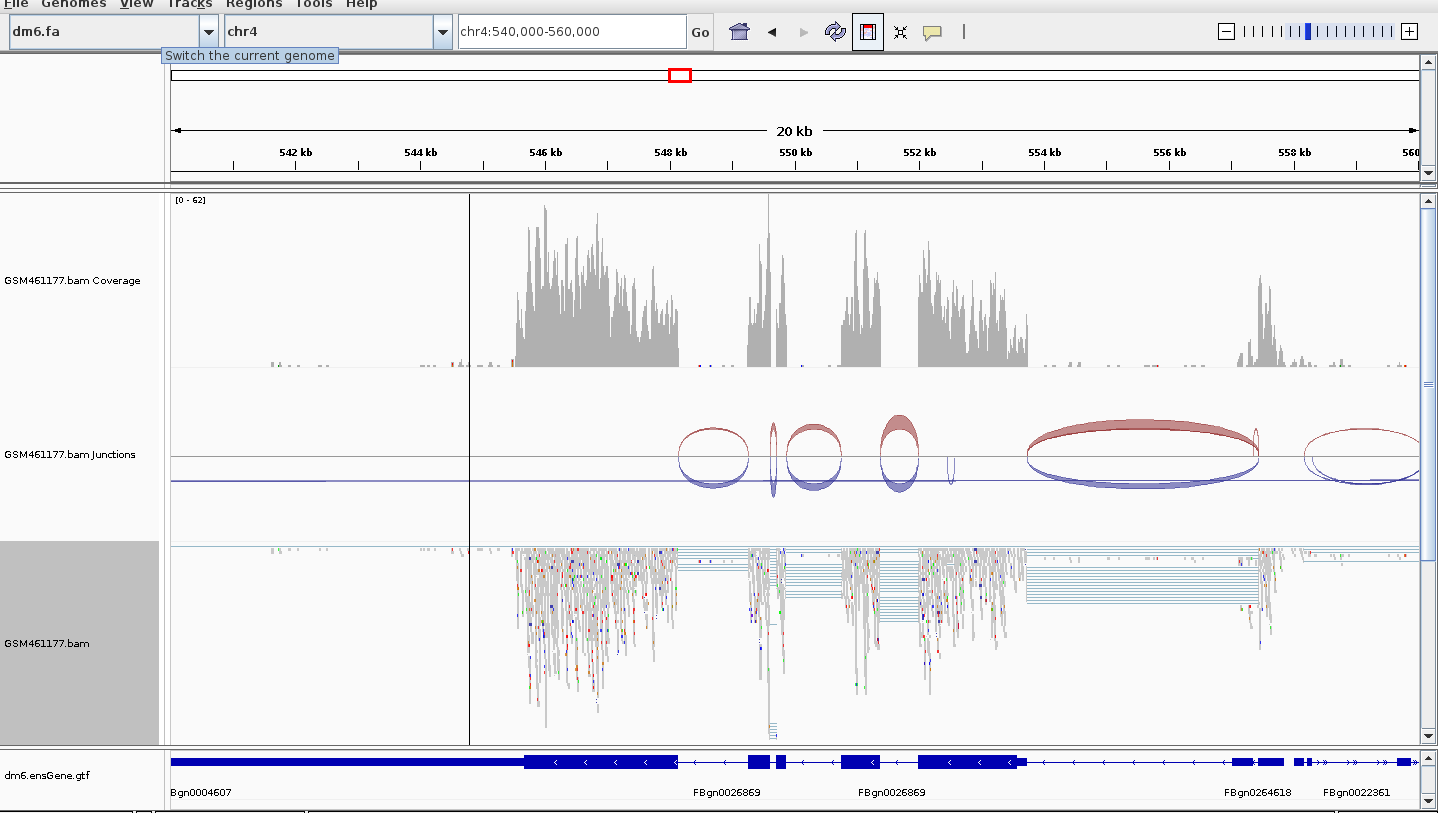



What we can see in figure above is that read coverage ( track 1 from top to bottom) spams exactly where an exon (bolded blue lines) is located( "dm6.ensGene.gtf"  track 4 from top to bottom). Track 2 ("bam junctions") shows where alignment actually covers an splice junction (across introns), which makes sense if we comperae with our track 4 of gene annotations that indicates exons imbetween introns (thin blue lines).    

We can also visualize the same location with a sashimi plot (right click on IGV to show this option):

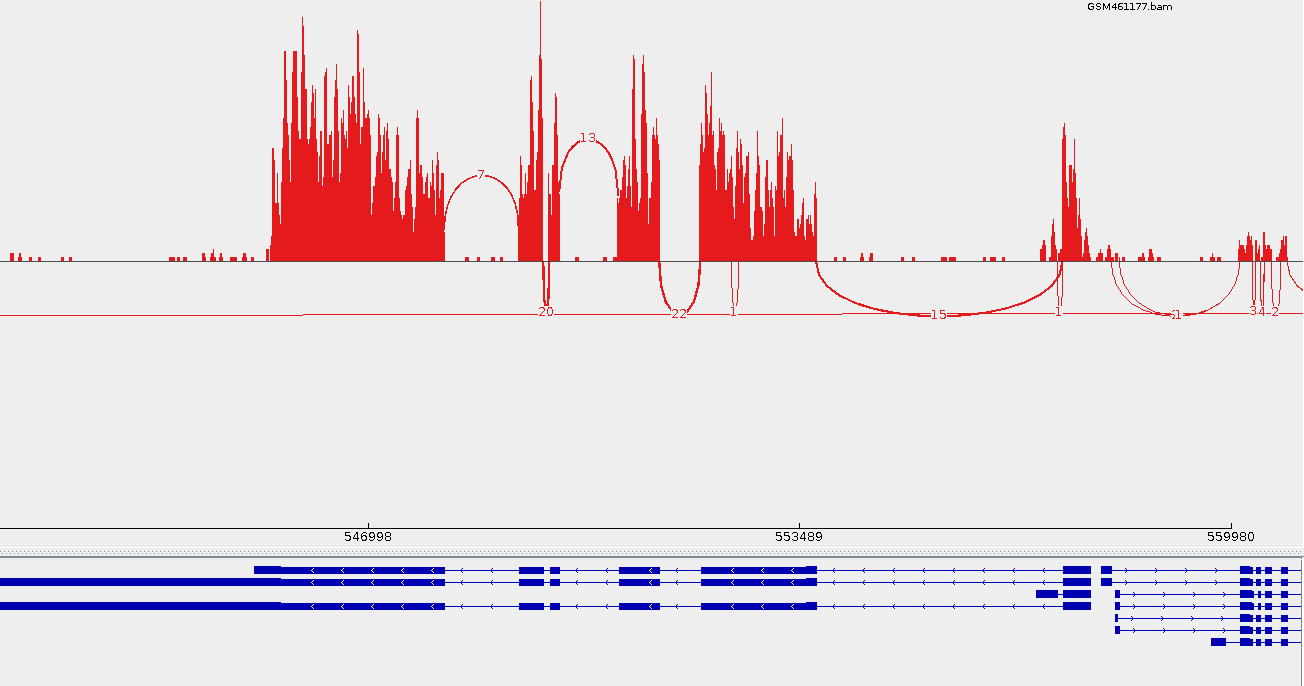

The sashimi plot show the read coverage as red bars and this red curves are the splice junctions. The numbers above the curves show the number of observed spliced junction reads. 

## 5. Quantifying reads per gene 
Since our objective is to compare the differential expression between Untreated and Treated samples, we need to quantify reads in such a manner that we can directly compare samples and conditions. 

In this section, we will tackle this problem using **featureCounts** tool.

Let's install featureCounts:

In [ ]:
%%capture 
!conda install -c bioconda subread

Create a directory to hold featureCounts output:

In [ ]:
!mkdir $RNA/FeatureCounts

Before executing featureCounts, we need to know if the sample is single-end or paired-end. We can check this using a previous scripts where we check the directory where the sample is in (Treated/sample or Untreated/sample). 
We will create a tsv file that contains this information:

In [ ]:
%%shell

cat $RNA/Post_MultiQC/multiqc_data/multiqc_general_stats.txt | tail +2 > $RNA/Post_MultiQC/nohead_multiqc_general_stats.txt
FILE=$RNA/Post_MultiQC/nohead_multiqc_general_stats.txt
while read line; do

    NAME=$(echo $line | cut -f 1 -d" ")
    # path of file with NAME 
    PATHNAME=$(find $RNA/CutAdapt/ -type f -name $NAME*)
    # Untreated or Treated 
    CONDITION=$( basename $(dirname $PATHNAME))
    echo "${NAME%%_*}   $CONDITION" >> $RNA/FeatureCounts/samples.tsv
   
done < $FILE

cat $RNA/FeatureCounts/samples.tsv | uniq -u | awk '{print $1, $2, "single"}' > $RNA/FeatureCounts/uniq_samples.tsv
cat $RNA/FeatureCounts/samples.tsv | uniq -d | awk '{print $1, $2, "paired"}' >> $RNA/FeatureCounts/uniq_samples.tsv

Let's check our table created:

In [ ]:
!cat  $RNA/FeatureCounts/uniq_samples.tsv

GSM461176 Untreated single
GSM461179 Treated single
GSM461182 Untreated single
GSM461177 Untreated paired
GSM461178 Untreated paired
GSM461180 Treated paired
GSM461181 Treated paired


In below command, we are considering only reads above quality score 10, and we consider counting the read or the fragment depeing if the sample is single-end or paired-end respectively. 

In [ ]:
%%shell

while read line; do 

    FILENAME=$(echo $line | cut -f 1 -d" ")
    COND=$(echo $line | cut -f 2 -d" ")
    READS=$(echo $line | cut -f 3 -d" ")

    if [[ $READS = "paired" ]]; then
        echo processing $READS $FILENAME
        featureCounts -t 'exon' -g 'gene_id' -Q 10 -p --countReadPairs \
            -a $RNA/Genome/dm6.ensGene.gtf \
            -o $RNA/FeatureCounts/counts_${FILENAME}.txt \
            $RNA/Samtools/${FILENAME}.bam
    else
        echo processing $READ $FILENAME
        featureCounts -t 'exon' -g 'gene_id' -Q 10  \
            -a $RNA/Genome/dm6.ensGene.gtf \
            -o $RNA/FeatureCounts/counts_${FILENAME}.txt \
            $RNA/Samtools/${FILENAME}.bam
    fi 
done < $RNA/FeatureCounts/uniq_samples.tsv

Finally, we aggregate all outputs with MultiQC

In [ ]:
%%shell 

mkdir $RNA/FeatureCounts/MultiQC
multiqc -m featureCounts $RNA/FeatureCounts -o $RNA/FeatureCounts/MultiQC

mkdir: cannot create directory ‘/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq//FeatureCounts/MultiQC’: File exists

  /// ]8;id=736622;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.14

|           multiqc | Only using modules: featureCounts
|           multiqc | Search path : /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FeatureCounts
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 17/17  
|    feature_counts | Found 7 reports
|           multiqc | Compressing plot data
|           multiqc | Previous MultiQC output found! Adjusting filenames..
|           multiqc | Use -f or --force to overwrite existing reports instead
|           multiqc | Report      : drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FeatureCounts/MultiQC/multiqc_report_1.html
|           multiqc | Data        : drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FeatureCounts/MultiQC/multiqc_data_1
|           multiqc | MultiQC complete


Let's check MultiQC summary of featureCounts:

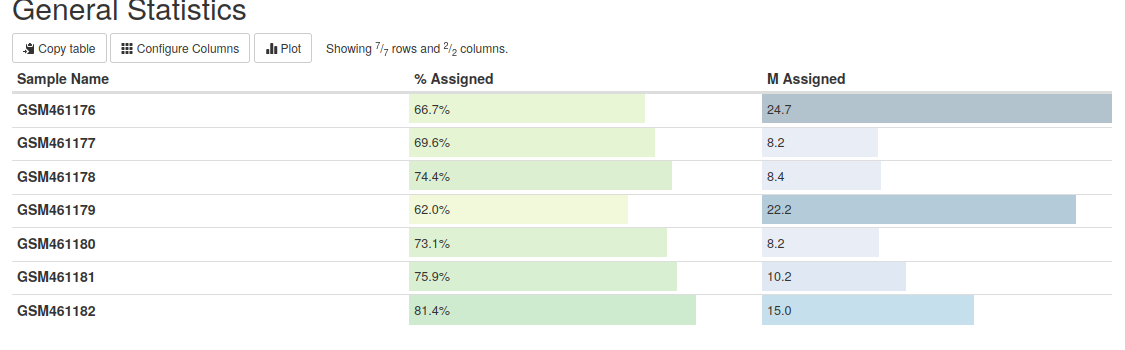



Since % Assigned is above 50% we can move on. 



## 6) Analysis of Differential Expressed Genes (DEGs)
We are ready to compare Untreated vs Treated samples and check which genes are differentially expresses by condition. We will use **[DESeq2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8)** tool to normalize reads, check for statistically significant differences and plot insightful graphs.

First, we need reads to be normalized because mostly of three factors:

* **sequencing depth of samples**: samples with more sequencing depth will have more counts of reads mapped.

* **length of gene**: genes that are longer have more reads mapped to them, which contributes to overall counts atributed to this gene. 

* **library composition**: cells from different origins can have more or less transcripts due to their state/physiology.  

Gene length is not a big problem in our case, because we are comparing the same gene against different samples (and conditions). 

Let's install DESeq2:

In [ ]:
%%capture 
!conda install -c bioconda bioconductor-deseq2

### A) Preparing input data to DESeq2 
Before running DESeq2, we need to make some changes to our featureCounts counts table, so it can serve as input to DESeq2. It requires that each gene has a column representing each sample and the value correspond to the read count of featureCounts. We will denote this file as "samples.tsv".

Also, a metadata file ("uniq_samples.tsv", see Step 5 where we execute featureCounts) need to have extra information about sample name, condition (treated or untreated) and if it is single-end or paired-end. Note that row order (top to bottom) of the meta file is the same order (left to right) of the columns.

In [ ]:
# Python script to obtain our counts table to DESeq2 

dfs = []
for i, sample in enumerate(glob.glob('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FeatureCounts/*.txt')):
    filename = sample.split("/")[-1].split(".")[0].split("_")[-1]
    print(filename)
    # all files have the same order of lines by gene 
    # we choose only one time the gene name 
    if i == 0:
        df = pd.read_csv(sample, sep='\t', header=None, skiprows=[0,1]).iloc[:,[0,6]]
        df.columns = ['gene_id',filename]
        dfs.append(df)
    else:
        df = pd.read_csv(sample, sep='\t', header=None, skiprows=[0,1]).iloc[:,[6]]
        df.columns = [filename]
        dfs.append(df)

df = pd.concat(dfs,axis=1)
df

GSM461176
GSM461179
GSM461182
GSM461177
GSM461178
GSM461180
GSM461181


,gene_id,GSM461176,GSM461179,GSM461182,GSM461177,GSM461178,GSM461180,GSM461181
0,FBgn0267431,2,10,0,0,0,1,0
1,FBgn0085804,0,0,0,0,0,0,0
2,FBgn0039987,0,0,0,0,0,0,0
3,FBgn0267798,19,27,9,9,18,11,9
4,FBgn0267797,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
17802,FBgn0267595,0,0,0,0,0,0,0
17803,FBgn0259864,0,0,0,0,0,0,0
17804,FBgn0085506,0,0,0,0,0,0,0
17805,FBgn0259870,0,0,0,0,0,0,0


In [ ]:
# Our metadata table 

meta = pd.read_csv('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FeatureCounts/uniq_samples.tsv',
                   sep=' ', header=None)
meta

,0,1,2
0,GSM461176,Untreated,single
1,GSM461179,Treated,single
2,GSM461182,Untreated,single
3,GSM461177,Untreated,paired
4,GSM461178,Untreated,paired
5,GSM461180,Treated,paired
6,GSM461181,Treated,paired


In [ ]:
!mkdir $RNA/DeSeq2/

In [ ]:
df.to_csv('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/samples.tsv', sep='\t')

### B) Running DeSeq2 in R

DESeq 2 will make statistical comparisons to our samples given some **factors** which can be interpreted as the source of variation. In our case, we have two factors, both condition(treated vs untreated) and type (single vs paired). NOTE that we must specify condition as our last factor in design parameter since by default DESeq2 use this to compute pvalues

In [ ]:
%%R
# Loading and pre-processing data 
countdata <- read.table("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/samples.tsv", header=TRUE, row.names=1)
metadata <- read.table("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FeatureCounts/uniq_samples.tsv", header=FALSE)

countmatrix <- as.matrix(countdata[,-1])
rownames(countmatrix) <- countdata[ , 1]
colnames(metadata) <- c("sample","condition", 'type')

# factors 
condition <- metadata['condition']
type <- metadata['type']

# Analysis with DESeq2 ----------------------------------------------------

library(DESeq2)

# Create a coldata frame and instantiate the DESeqDataSet. See ?DESeqDataSetFromMatrix
coldata = data.frame(row.names=colnames(countmatrix), condition, type)

dds <- DESeqDataSetFromMatrix(countData=countmatrix, colData=coldata, design= ~type + condition)

# Run the DESeq pipeline
dds <- DESeq(dds)

# DESeq2 DOES NOT return normalized counts, but we can explicitly command it 
ndds <- estimateSizeFactors(dds)
norm.counts <- counts(ndds, normalized=TRUE)



R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [ ]:
%%R 

#saving 
write.csv(norm.counts,'/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/norm_counts.csv')


# checking 
head(norm.counts)


            GSM461176 GSM461179 GSM461182 GSM461177 GSM461178 GSM461180
FBgn0267431 0.9910994   5.22630   0.00000   0.00000   0.00000  1.521955
FBgn0085804 0.0000000   0.00000   0.00000   0.00000   0.00000  0.000000
FBgn0039987 0.0000000   0.00000   0.00000   0.00000   0.00000  0.000000
FBgn0267798 9.4154446  14.11101   7.45289  14.00384  27.72395 16.741509
FBgn0267797 0.4955497   0.00000   0.00000   0.00000   0.00000  0.000000
FBgn0058182 0.0000000   0.00000   0.00000   0.00000   0.00000  0.000000
            GSM461181
FBgn0267431   0.00000
FBgn0085804   0.00000
FBgn0039987   0.00000
FBgn0267798  10.99654
FBgn0267797   0.00000
FBgn0058182   0.00000


### C) Calculating statistics 
We will consider p-value $< 0.05$ as significant in this case:

We can inspect the results of DESeq2.
Filtering by p-value $< 0.05$ there are:
 

*   432 upregulated genes (log2 Fold Change $>0$)
*   538 downregulated genes (log2 Fold Change $<0$)



In [ ]:
%%R 
res05 <- results(dds, contrast=c("condition","Treated","Untreated"), alpha=0.05)
summary(res05)


out of 15334 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 432, 2.8%
LFC < 0 (down)     : 538, 3.5%
outliers [1]       : 0, 0%
low counts [2]     : 7074, 46%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



We can inspect if our pasila gene/ps (FBgn0261552) is downregulated, which should be since it was silenced as part of the experiment:

In [ ]:
%%R

res05['FBgn0261552',]

log2 fold change (MLE): condition Treated vs Untreated 
Wald test p-value: condition Treated vs Untreated 
DataFrame with 1 row and 6 columns
             baseMean log2FoldChange     lfcSE      stat     pvalue        padj
            <numeric>      <numeric> <numeric> <numeric>  <numeric>   <numeric>
FBgn0261552   5991.15       -1.77803  0.150682  -11.7999 3.9098e-32 1.40413e-29


According to the pvalue which is $<<0.05$ and to the log2FoldChange of -1.77(Treated vs Untreated), indeed ps gene is downregulated.  

### D) PCA

Let's plot a PCA to verify that our samples form clusters according to our factors 1)condition (Treated and Untreated) and 2)type (single vs paired):

In [ ]:
%%R
vsd <- vst(dds, blind=FALSE)
rld <- rlog(dds, blind=FALSE)

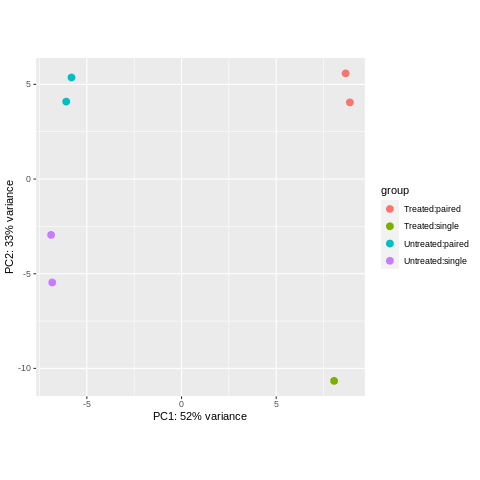

In [ ]:
%%R
plotPCA(vsd, intgroup=c("condition", "type"))

As it can be seen from PCA, samples of the same type and of the same condition are closer. We can also draw lines that can separate samples in both ways: by type or by condition

Let's save the result and filter by p-value and fold change

In [ ]:
%%R
write.csv(as.data.frame(res05), 
          file="/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/results.csv")

### E) Filtering results 
We will remove results with adjusted p-value below $0.05$ or NA (because of low read counts to a gene DESeq2 input NA) and also select only genes with absolute Fold Change $> 2$: 

In [ ]:
results = pd.read_csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/results.csv", index_col=0)
filter = results[(results['padj'] <= 0.05) & (abs(results['log2FoldChange']) > 1)]
filter

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FBgn0259821,173.409906,1.082213,0.182242,5.938323,2.879515e-09,1.101148e-07
FBgn0085334,49.769808,-1.254011,0.416206,-3.012955,2.587176e-03,2.568518e-02
FBgn0037223,24.365138,-2.265380,0.481820,-4.701715,2.579856e-06,6.536690e-05
FBgn0037290,68.727709,3.062922,0.316102,9.689650,3.336700e-22,6.263896e-20
FBgn0000071,319.506665,2.601485,0.162171,16.041642,6.540171e-58,5.402182e-55
...,...,...,...,...,...,...
FBgn0010097,107.771301,1.074808,0.233502,4.603003,4.164428e-06,1.002294e-04
FBgn0266020,20.259935,1.693236,0.526899,3.213587,1.310883e-03,1.475189e-02
FBgn0262620,255.344955,1.109795,0.175987,6.306115,2.861273e-10,1.374077e-08
FBgn0013680,76.542563,2.321319,0.494745,4.691945,2.706193e-06,6.794273e-05


Now we have $207$ genes following that criteria that we can annotate and do and functional enrichment analysis.

In [ ]:
filter.to_csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/results_pval-5e-2_FC-gt-2.csv")

## Annotation of DE genes
We will download an Emsembl annotation file to recover gene name of each gene ID (like FBgn0039155). This will make easier to identify genes.

In [ ]:
%%shell

wget https://ftp.ensembl.org/pub/release-109/gtf/drosophila_melanogaster/Drosophila_melanogaster.BDGP6.32.109.gtf.gz \
    -P /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Genome

gzip -d /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Genome/*.gz

Inspecting this file, we can see last column has a "gene_name" part. We need to extract this and assign to the appropriate "gene_id"

In [ ]:
!head /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Genome/Drosophila_melanogaster.BDGP6.32.109.gtf

#!genome-build BDGP6.32
#!genome-version BDGP6.32
#!genome-build-accession GCA_000001215.4
#!genebuild-last-updated 2020-08
3R	FlyBase	gene	7145880	7150968	.	-	.	gene_id "FBgn0250732"; gene_name "gfzf"; gene_source "FlyBase"; gene_biotype "protein_coding";
3R	FlyBase	transcript	7145880	7150968	.	-	.	gene_id "FBgn0250732"; transcript_id "FBtr0091512"; gene_name "gfzf"; gene_source "FlyBase"; gene_biotype "protein_coding"; transcript_name "gfzf-RB"; transcript_source "FlyBase"; transcript_biotype "protein_coding"; tag "Ensembl_canonical";
3R	FlyBase	exon	7150166	7150968	.	-	.	gene_id "FBgn0250732"; transcript_id "FBtr0091512"; exon_number "1"; gene_name "gfzf"; gene_source "FlyBase"; gene_biotype "protein_coding"; transcript_name "gfzf-RB"; transcript_source "FlyBase"; transcript_biotype "protein_coding"; exon_id "FBtr0091512-E1"; tag "Ensembl_canonical";
3R	FlyBase	CDS	7150166	7150630	.	-	0	gene_id "FBgn0250732"; transcript_id "FBtr0091512"; exon_number "1"; gene_name "gfzf"; gene_sourc

In [ ]:
annot = pd.read_csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Genome/Drosophila_melanogaster.BDGP6.32.109.gtf",
                    skiprows=4, sep='\t', header=None)

In [ ]:
d = {}
info = annot[8].str.split(";")
for row in info:
    for i,el in enumerate(row):
        if 'gene_id' in el:
            # we need to remove "gene_id" and extra double quotes
            id = el.split("gene_id")[-1].replace('"', '').strip()
            d[id] = ''
        if 'gene_name' in el:
            d[id] = [el.split('gene_name')[-1].replace('"', '').strip()]

        # transposable elements does not have gene name 
        if (i == len(row)-1) and (d[id] == ''):
            del d[id] 

Now we merge our filter table (from last step) with our new annotation table that we create using gene_id and gene_name parsed from Emsembl gtf file:

In [ ]:
genes = pd.DataFrame(d).T
genes.columns = ['gene_name']
final = pd.merge(filter,genes,left_index=True,right_index=True)
final

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
FBgn0259821,173.409906,1.082213,0.182242,5.938323,2.879515e-09,1.101148e-07,CG42402
FBgn0085334,49.769808,-1.254011,0.416206,-3.012955,2.587176e-03,2.568518e-02,CG34305
FBgn0037223,24.365138,-2.265380,0.481820,-4.701715,2.579856e-06,6.536690e-05,TwdlU
FBgn0037290,68.727709,3.062922,0.316102,9.689650,3.336700e-22,6.263896e-20,CG1124
FBgn0000071,319.506665,2.601485,0.162171,16.041642,6.540171e-58,5.402182e-55,Ama
...,...,...,...,...,...,...,...
FBgn0010097,107.771301,1.074808,0.233502,4.603003,4.164428e-06,1.002294e-04,gammaTub37C
FBgn0266020,20.259935,1.693236,0.526899,3.213587,1.310883e-03,1.475189e-02,lncRNA:CR44785
FBgn0262620,255.344955,1.109795,0.175987,6.306115,2.861273e-10,1.374077e-08,lncRNA:CR43144
FBgn0013680,76.542563,2.321319,0.494745,4.691945,2.706193e-06,6.794273e-05,mt:ND2


In [ ]:
final.to_csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/gene-name_results_pval-5e-2_FC-gt-2.csv")

## Visualization of DEGs with heatmap and volcano plot 

Finally, we can plot a heatmap to show all DEGs (padj $\leq 0.05$ and abs log2FC  $ \geq 2$) across all samples. We will use **ggplot2** and **ComplexHeatmap** packages in **R language**. Let's install those packages  

### A) installing packages:

In [ ]:
%%R

install.packages('ggplot2')
install.packages('tidyr')
install.packages('dplyr')

In [ ]:
%%R
install.packages('devtools')
library('devtools')
install_github('jokergoo/ComplexHeatmap')

In [ ]:
%%R

library(tidyr)
library(ggplot2)
library(dplyr)
library(ComplexHeatmap)

### B) Get top 20 most significant DEGs 

It would be better to visualize just the most significant DEGs to avoid a cluttered heatmap. We will select the top 20 DEGs by the lowest p-value adjusted:

In [ ]:
!mkdir /content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs

In [ ]:
%%R

df <- read.csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/gene-name_results_pval-5e-2_FC-gt-2.csv")
top20 <- df %>% arrange(padj) %>% head(20)
write.csv(top20, '/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs/top20.csv', row.names=FALSE)

Let's see our top 20 genes:

In [ ]:
pd.read_csv('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs/top20.csv')

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
0,FBgn0026562,43559.937389,-2.467675,0.086485,-28.533088,4.554432e-179,3.761961e-175,SPARC
1,FBgn0003360,4360.878559,-3.173334,0.112337,-28.248318,1.492707e-175,6.164880e-172,sesB
2,FBgn0039155,729.732616,-4.623902,0.169404,-27.295171,4.840136e-164,1.332651e-160,Kal1
3,FBgn0025111,1500.627515,2.808586,0.104737,26.815697,2.120124e-158,4.378057e-155,Ant2
4,FBgn0029167,3640.541172,-2.193800,0.097974,-22.391657,4.746086e-111,7.840535e-108,Hml
5,FBgn0035085,639.760326,-2.615184,0.132146,-19.790044,3.627246e-87,4.993508e-84,CG3770
6,FBgn0039827,262.937305,-4.051956,0.215995,-18.759499,1.619177e-78,1.910629e-75,CG1544
7,FBgn0264475,647.068544,-2.520173,0.143367,-17.578464,3.602039e-69,3.719105e-66,lncRNA:CR43883
8,FBgn0034736,220.272958,-3.539091,0.216094,-16.377552,2.766577e-60,2.539103e-57,gas
9,FBgn0000071,319.506665,2.601485,0.162171,16.041642,6.540171e-58,5.402182e-55,Ama


### C) Extract normalized counts of genes
A simple join of the normalized counts and our top20 tables, so we have the gene name and not the gene ID with their respective normalized counts:

In [ ]:
%%R
top20 <- read.csv('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs/top20.csv')
norm.counts <- read.csv('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/norm_counts.csv')

top20_counts <- inner_join(top20, norm.counts)

Joining with `by = join_by(X)`


In [ ]:
%%R 
top20_counts_only <- top20_counts %>% select( matches('GSM|gene'))
write.csv(top20_counts_only, '/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs/top20_counts.csv', row.names=FALSE)

In [ ]:
pd.read_csv('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs/top20_counts.csv')

,gene_name,GSM461176,GSM461179,GSM461182,GSM461177,GSM461178,GSM461180,GSM461181
0,SPARC,51227.947437,9164.316517,51978.107933,76629.036234,86144.475398,14329.209820,15446.468384
1,sesB,7186.957531,741.089297,8338.127211,6021.653067,6678.391656,797.504615,762.426536
2,Kal1,1209.141307,42.333028,1331.582933,1149.871219,1261.439752,50.224527,63.535545
3,Ant2,358.777994,2447.476148,385.894059,455.902932,420.479917,3180.886726,3254.974828
4,Hml,5229.040603,1195.777370,5466.280437,5836.491125,5347.642027,1302.793798,1105.762845
5,CG3770,844.416716,144.245872,1001.171496,1040.952429,1088.935171,176.546823,182.053772
6,CG1544,379.591082,26.131498,423.986606,491.690535,466.686502,18.263464,34.211447
7,lncRNA:CR43883,950.464355,181.352599,1229.726776,869.794332,967.257832,153.717492,177.166423
8,gas,364.229041,26.131498,313.849460,421.671313,343.468944,39.570840,32.989610
9,Ama,91.181148,508.518960,68.732204,108.918789,118.596900,627.045613,713.553040


In [ ]:
%%R 
row.names(top20_counts_only) = top20_counts_only[,'gene_name']
log_counts <- log(top20_counts_only[,-1], 2)

In [ ]:
%%R

# select only counts 
top20.counts <- top20_counts_only[,-1]
# get means of each row 
top20.counts$mean <- rowMeans(top20.counts)
# calculate sd for axis = 1 (rows) and do not select mean row 
top20.counts$sd <- top20.counts %>% select(-'mean') %>% apply(1, sd)

# calculate z-score = (xi - mean) / sd for each gene (row)
z_score <- apply(top20.counts[, 1:7], 2, function (col) {(col - top20.counts$mean)/top20.counts$sd})
write.csv(z_score,'/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs/top20_z_scores.csv')



### D) Visualizing the heatmap 

In [ ]:
%%R
meta <- read.csv('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/FeatureCounts/uniq_samples.tsv', sep=' ', header=FALSE)


df <- meta %>% select('V1', 'V2') %>% unite(fullname, sep='_')
colnames(z_score) <- df$fullname

In [ ]:
%%R
png('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs/top20_heatmap.png')
Heatmap(z_score, cluster_rows=TRUE, cluster_columns=TRUE, name='Z-score', column_title = "Z-score of top 20 DEGs",
        column_title_gp = gpar(fontsize = 20, fontface = "bold"), 
        heatmap_width = unit(12, "cm"), heatmap_height = unit(16, "cm"))
#dev.off()

Let's see our plot:

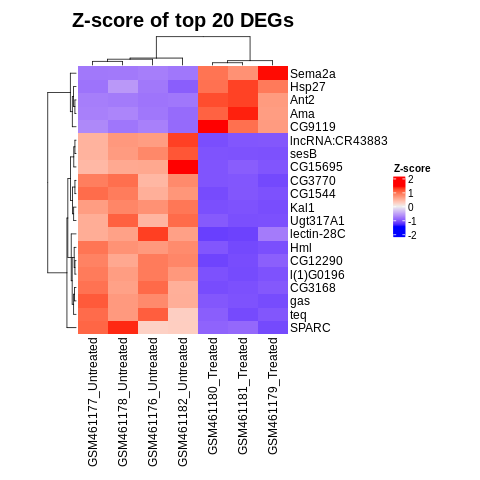

### E) Volcano plot 

We need to install the **EnhancedVolcano** package in R:

In [ ]:
%%R 

if (!requireNamespace('BiocManager', quietly = TRUE))
    install.packages('BiocManager')

BiocManager::install('EnhancedVolcano')

We will also use all the results from DeSeq2 instead of just the filtered by padj and log2FC. So, we can merge the results with the gene names as we previously did in Annotation of DEGs chapter:


In [ ]:

# load annotation file from EMSEMBL 
annot = pd.read_csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/Genome/Drosophila_melanogaster.BDGP6.32.109.gtf",
                    skiprows=4, sep='\t', header=None)
# parse annotation file 
d = {}
info = annot[8].str.split(";")
for row in info:
    for i,el in enumerate(row):
        if 'gene_id' in el:
            # we need to remove "gene_id" and extra double quotes
            id = el.split("gene_id")[-1].replace('"', '').strip()
            d[id] = ''
        if 'gene_name' in el:
            d[id] = [el.split('gene_name')[-1].replace('"', '').strip()]

        # transposable elements does not have gene name 
        if (i == len(row)-1) and (d[id] == ''):
            del d[id] 


In [ ]:
# create a dataframe  from parsed file 
genes = pd.DataFrame(d).T
genes.columns = ['gene_name']

# load DeSeq2 results 
results = pd.read_csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/results.csv", index_col=0)

# merge 
results_named = pd.merge(results,genes,left_index=True,right_index=True)
results_named.to_csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/results_named.csv", index=False)

In [ ]:
%%R 

library(EnhancedVolcano)
png('/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DEGs/volcano.png')
df <- read.csv("/content/drive/MyDrive/Bioinformatics_Pipelines/RNA-seq/DeSeq2/results_named.csv")

EnhancedVolcano(df, x='log2FoldChange', y='padj', lab=df$gene_name)
#dev.off()

Let's check our volcano plot:

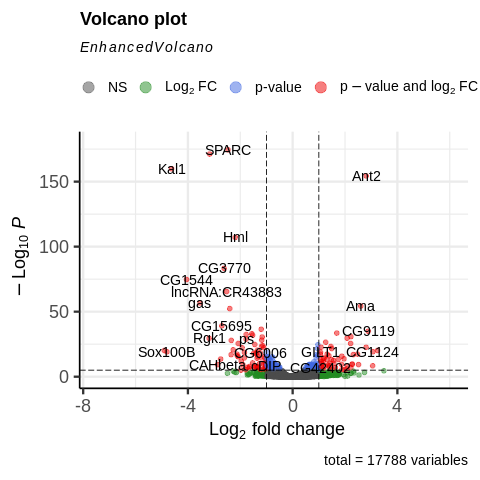